In [ ]:
"""Test if marker recognization is sufficient"""
from pvc_tensile_experiment.Functions import *

# variable inputs
folderName = 'Data/Image Data/PVC P8 Test_0'

# set pixel area limits for the search region and the
# the lower color bound
searchRegion = [60, 4500]
lowerColorLims = [80, 150, 130] # min [80, 80, 100], max [80, 150, 125]

# define the opening kernel and use
kernelSize = 3
useKernel = False

# check the particle areas are increasing and verify if there are abnormal changes to position
MaskCheck(folderName, searchRegion, lowerColorLims, useKernel, kernelSize)


In [ ]:
"""Run the particle tracking, compute strain, and couple stress and strain"""
from pvc_tensile_experiment.Functions import *

# find the tracked particles
tracked = ParticleIdentify(folderName, searchRegion, lowerColorLims, useKernel, kernelSize)

# process the data and compile, getting strain and stress calculations 
axDist, axStrain, transDist, transStrain, stress  = StrainFunction(folderName, tracked)


In [ ]:
"""Overlay the individual modeling dataset on a plot"""
from pvc_tensile_experiment.Functions import DataReader
import os; import matplotlib.pyplot as plt
import numpy as np

# the desired plasticizer ratio 
plastiRatio = 'P2'

# list the processed file names
fileNames = [i for i in os.listdir('Data/Modeling data') if i.find(f'{plastiRatio}') != -1]

# preallocate the suplots
fig, axs = plt.subplots(1,2, layout = "constrained")
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")

for name in fileNames:
    # read the processed data files 
    axDist, axStrain, transDist, transStrain, stress = DataReader(name)
    
    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio

    # remove csv from the name
    name = name.removesuffix('.csv').removeprefix('PVC ')

    # plot the engineering axial and transverse strain per frame
    axs[0].plot(axStrain, label = f'{name}')
    axs[1].plot(transStrain, label = f'{name}')
    axs[0].set_title('Axial Strain')
    axs[1].set_title('Transverse Strain')
    axs[0].set_xlabel('Frame')
    axs[1].set_xlabel('Frame')
    axs[0].set_ylabel('Strain (pxl/pxl)')
    axs[1].set_ylabel('Strain (pxl/pxl)')
    axs[0].legend(fontsize = 7)
    axs[1].legend(fontsize = 7)

    # plot poissons ratio 
    axs1.plot(axStrain, transStrain, label = f'{name}')
    axs1.set_title("Poisson's Ratio")
    axs1.set_xlabel('Axial Strain (pxl/pxl)')
    axs1.set_ylabel('Transverse Strain (pxl/pxl)')
    axs1.legend(fontsize = 7)

    # plot engineering stress-strain and true stress-strain
    axs2[0].plot(axStrain, stress, label = f'{name}')   
    axs2[1].plot(axStrainTrue, stressTrue, label = f'{name}')
    axs2[0].set_xlabel('Engineering Strain (pxl/pxl)')
    axs2[1].set_xlabel('True Axial Strain (pxl/pxl)')
    axs2[0].set_ylabel('Stress (MPa)')
    axs2[1].set_ylabel('True Stress (MPa)')
    axs2[0].set_title('Engineering Stress-Strain')
    axs2[1].set_title('True Stress-Strain')
    axs2[0].legend(fontsize = 7)
    axs2[1].legend(fontsize = 7)

plt.show()


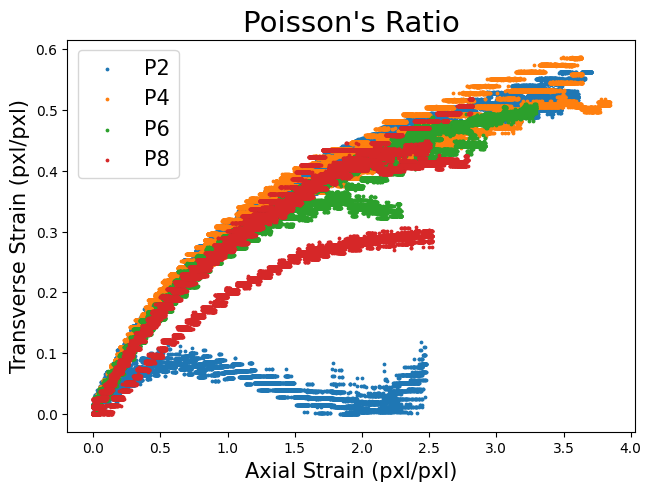

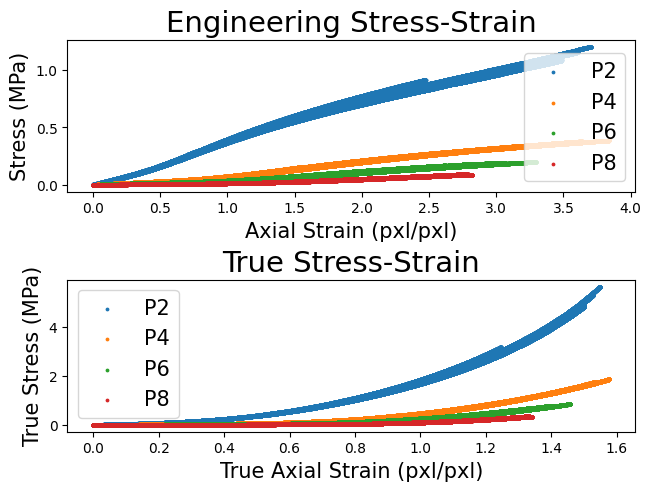

In [ ]:
"""Overlay the all modeling datasets indivually"""
from pvc_tensile_experiment.Functions import DataComplile
import matplotlib.pyplot as plt; import numpy as np

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(2,1, layout = "constrained")


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = DataComplile(plastiRatio)

    # find true strain and stress from engineering strain
    stretchRatio = 1 + axStrain
    axStrainTrue = np.log(stretchRatio) 
    stressTrue = stress*stretchRatio
    
    # define marker size
    size = 3

    # plot poissons ratio 
    axs1.scatter(axStrain, transStrain, label = f'{plastiRatio}', s = size)
    axs1.set_title("Poisson's Ratio", fontsize = 21)
    axs1.set_xlabel('Axial Strain (pxl/pxl)', fontsize = 15)
    axs1.set_ylabel('Transverse Strain (pxl/pxl)', fontsize = 15)
    axs1.legend(fontsize = 15)

    # plot engineering stress-strain and true stress-strain
    axs2[0].scatter(axStrain, stress, s = size, label = f'{plastiRatio}')   
    axs2[1].scatter(axStrainTrue, stressTrue, label = f'{plastiRatio}', s = size)
    axs2[0].set_xlabel('Axial Strain (pxl/pxl)', fontsize = 15)
    axs2[1].set_xlabel('True Axial Strain (pxl/pxl)', fontsize = 15)
    axs2[0].set_ylabel('Stress (MPa)', fontsize = 15)
    axs2[1].set_ylabel('True Stress (MPa)', fontsize = 15)
    axs2[0].set_title('Engineering Stress-Strain', fontsize = 21)
    axs2[1].set_title('True Stress-Strain', fontsize = 21)
    axs2[0].legend(fontsize = 15)
    axs2[1].legend(fontsize = 15)

    
plt.show()

Elastic Modulus: [0.2909667 0.0008463], Poissons Ratio: [0.36103878 0.01359774]


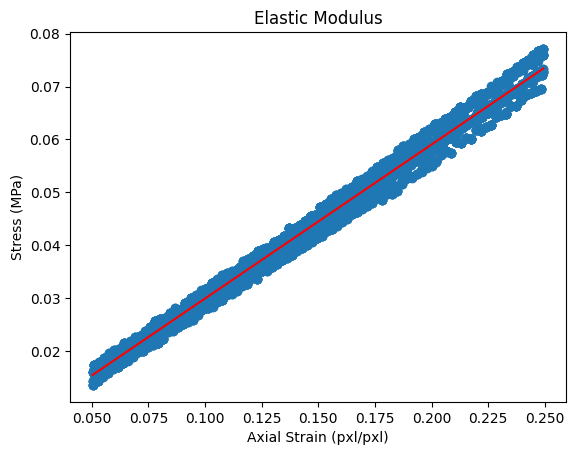

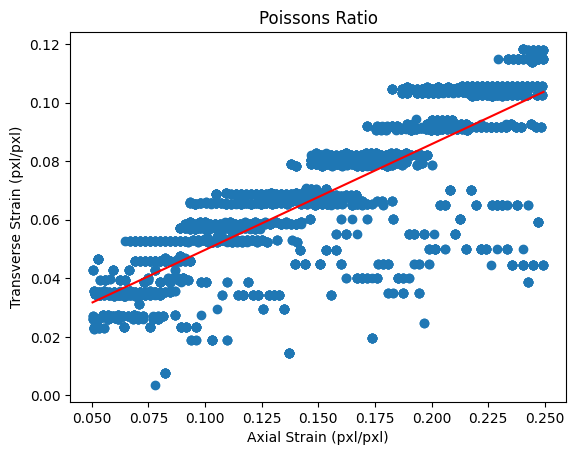

In [5]:
"""Combined elastic modulus and poissons ratio"""
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = DataComplile(plastiRatio)

# define the elastic region
elasRegion = [list(axStrain).index(i) for i in axStrain if i < 0.25 and i > 0.05]
elasAxStrain = axStrain[elasRegion]
elasTransStrain = transStrain[elasRegion]
elasStress = stress[elasRegion]

# curve fit the elastic region. find the 
xfit = np.linspace(elasAxStrain[0], elasAxStrain[-1])
poptE, pcovE = curve_fit(LinearFit, elasAxStrain, elasStress)
poptP, pcovP = curve_fit(LinearFit, elasAxStrain, elasTransStrain)
print(f'Elastic Modulus: {poptE}, Poissons Ratio: {poptP}')

# plot engineering stress vs strain
plt.figure(0)
plt.scatter(elasAxStrain, elasStress)
plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Stress (MPa)')
plt.title('Elastic Modulus')
plt.show()

# plot poissons ratio
plt.figure(1)
plt.scatter(elasAxStrain, elasTransStrain)
plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'r')
plt.xlabel('Axial Strain (pxl/pxl)')
plt.ylabel('Transverse Strain (pxl/pxl)')
plt.title('Poissons Ratio')
plt.show()

In [ ]:
"""Combine modeling datasets into one csv"""
from pvc_tensile_experiment.Functions import *; import numpy as np


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, _, stress = DataComplile(plastiRatio)

    # convert to true stress-strain
    stretchRatio = 1 + axStrain
    trueStrain = np.log(stretchRatio) 
    trueStress = stress*stretchRatio

    # save every 50th iteration
    index = np.arange(0, len(trueStrain), 100)
    trueStrain = trueStrain[index]  
    trueStress = trueStress[index]

    df = pd.DataFrame(columns = ["True Strain (pxl/pxl)", "True Stress (Pa)"])
    df["True Strain (pxl/pxl)"] = trueStrain    
    df["True Stress (Pa)"] = trueStress*10**6
    df.to_csv(f"Data/{plastiRatio}.csv", sep = ',', header = True, index = False)

In [ ]:
"""Hyperelastic model fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
axDist, axStrain, transDist, transStrain, stress = DataComplile(plastiRatio)

# Convert engineering stress-strain to true stress-strain
def eng_to_true_stress_strain(eng_stress, eng_strain):
    true_strain = np.log(1 + eng_strain)
    true_stress = eng_stress * (1 + eng_strain)  # Assuming volume conservation
    return true_stress, true_strain


# Define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def gent(params, stretch):
    C1, Jm = params
    I1 = stretch**2 + 2 / stretch
    return 2 * C1 * (I1 - 3) / (1 - (I1 - 3) / Jm)

def arruda_boyce(params, stretch):
    C1, lambda_m = params
    I1 = stretch**2 + 2 / stretch
    return 2 * C1 * (I1 - 3) * (1 + (I1 - 3) / (5 * lambda_m**2))

def ogden(params, stretch):
    mu, alpha = params
    return mu * (stretch**(alpha - 1) - stretch**(-alpha - 1))


# Define fitting function
def fit_model(model, stretch, true_stress, param_guess):
    def residuals(params):
        return model(params, stretch) - true_stress
    opt_params, _ = opt.least_squares(residuals, param_guess).x, None
    return opt_params

# Compute R-squared
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Load data (replace with actual stress-strain data)
eng_strain = axStrain
eng_stress = stress

true_stress, true_strain = eng_to_true_stress_strain(eng_stress, eng_strain)
stretch = np.exp(true_strain)

# Models and initial guesses
models = {
    "Neo-Hookean": (NeoHookean, [1.0]),
    "Mooney-Rivlin": (MooneyRivlin, [1.0, 0.1]),
    "Yeoh": (Yeoh, [1.0, -0.1, -0.01]),
    "Gent": (gent, [1.0, 100]),
    "Arruda-Boyce": (arruda_boyce, [1.0, 10]),
    "Ogden": (ogden, [1.0, 2.0])
}

# Fit models
fit_results = {}
for name, (model, guess) in models.items():
    params = fit_model(model, stretch, true_stress, guess)
    pred_stress = model(params, stretch)
    r2 = r_squared(true_stress, pred_stress)
    fit_results[name] = (params, r2)

# Print results
for name, (params, r2) in fit_results.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(true_strain, true_stress, label="Data", color="black")

for name, (params, _) in fit_results.items():
    plt.plot(true_strain, models[name][0](params, stretch), label=name)

plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()


In [ ]:
"""Cross link fitment"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Constants for PVC Polymer
R = 8.314  # Universal gas constant (J/mol·K)
T = 0  # Room temperature (K)
nu = 5e-6  # Cross-link density (mol/cm³)
Mc = 30000  # Molecular weight between cross-links (g/mol)

# Engineering stress-strain data (Replace with real experimental data)
engineering_strain = axStrain
engineering_stress = stress

# Convert engineering to true stress and strain
true_strain = np.log(1 + engineering_strain)
true_stress = engineering_stress * (1 + engineering_strain)

# Define the modified Yeoh model function
def modified_yeoh(I1, C1, C2, C3):
    additional_term = (nu * R * T / Mc) * (I1 - 3)  # Cross-link effect
    return C1 * (I1 - 3) + C2 * (I1 - 3)**2 + C3 * (I1 - 3)**3 + additional_term

# Function to fit true stress-strain data using Yeoh model
def fit_yeoh(true_strain, true_stress):
    I1 = 2 * (true_strain + 1)  # First invariant approximation for uniaxial tension
    
    def objective(params):
        C1, C2, C3 = params
        return modified_yeoh(I1, C1, C2, C3) - true_stress
    
    initial_guess = [0.20409796, -0.00736779,  0.00022124]  # Initial parameter estimates
    params_opt, _ = opt.least_squares(objective, initial_guess).x, None
    
    # Compute R-squared value
    fitted_stress = modified_yeoh(I1, *params_opt)
    ss_res = np.sum((true_stress - fitted_stress) ** 2)
    ss_tot = np.sum((true_stress - np.mean(true_stress)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return params_opt, r_squared, fitted_stress

# Fit the model
params_opt, r_squared, fitted_stress = fit_yeoh(true_strain, true_stress)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(true_strain, true_stress, label='True Stress Data', color='blue')
plt.plot(true_strain, fitted_stress, label=f'Modified Yeoh Fit (R²={r_squared:.4f})', color='red')
plt.xlabel('True Strain')
plt.ylabel('True Stress (MPa)')
plt.legend()
plt.title('Curve Fitting with Modified Yeoh Model for Over-Plasticized PVC')
plt.show()

# Print optimized parameters
print(f"Optimized C1: {params_opt[0]:.4f}, C2: {params_opt[1]:.4f}, C3: {params_opt[2]:.4f}")
print(f"R-squared: {r_squared:.4f}")
